In [1]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
import colorcet as cc
import copy
import os

from functions import map_scatter, glasbey

In [2]:
# read in dimred_clstr data
data_path = os.path.join('..', 'outputs', 'dimred_clstr.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    print(f"File not found: {data_path}.\nCheck data path.")

In [3]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1', 'UMAP2', 'PC1', 'PC2', 'Cluster_UMAP']
markers = [col for col in df.columns if col not in metadata]
print(markers)

['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']


In [7]:
# melt the dataframe so that all markers are in one column called 'Intensity' 
melted = df.melt(id_vars=metadata, var_name="Marker", value_name="Intensity")
melted.head()

Image                             Object ID Classification  \
0  Slide10_Scan1.ome.tif  f5505ea9-ddff-4fea-90dd-a425402a544d       Other/NA   
1  Slide10_Scan1.ome.tif  4b313e44-f97c-43e8-99a7-31b9ab2a45c0       Other/NA   
2  Slide10_Scan1.ome.tif  e0673808-3a80-4490-b565-2fa9b3425738           CD56   
3  Slide10_Scan1.ome.tif  e2036b6c-b8ba-42fc-b05c-1e0c8c853192       Other/NA   
4  Slide10_Scan1.ome.tif  5afebba8-c97a-4d69-b9e2-395d49cebd90       Other/NA   

          Parent  Centroid X µm  Centroid Y µm     UMAP1     UMAP2       PC1  \
0  Slide 10 C1-1         4004.2         1674.9  6.738408  6.757998 -5.286668   
1  Slide 10 C1-1         4055.9         1675.2  7.695970  6.541201 -5.876908   
2  Slide 10 C1-1         4070.8         1675.8  7.024744  7.164611 -4.714929   
3  Slide 10 C1-1         3904.7         1677.1  6.188785  6.723613 -4.541659   
4  Slide 10 C1-1         3921.0         1676.8  6.777853  6.659215 -5.077836   

        PC2  Cluster_UMAP Marker  Intensity  
0 -0.298409            32   DAPI  -0.443124  
1 -0.926938            80   DAPI  -1.365461  
2 -0.376258            80   DAPI  -0.981877  
3  0.661836            32   DAPI  -0.554083  
4 -0.181445            32   DAPI  -0.943903

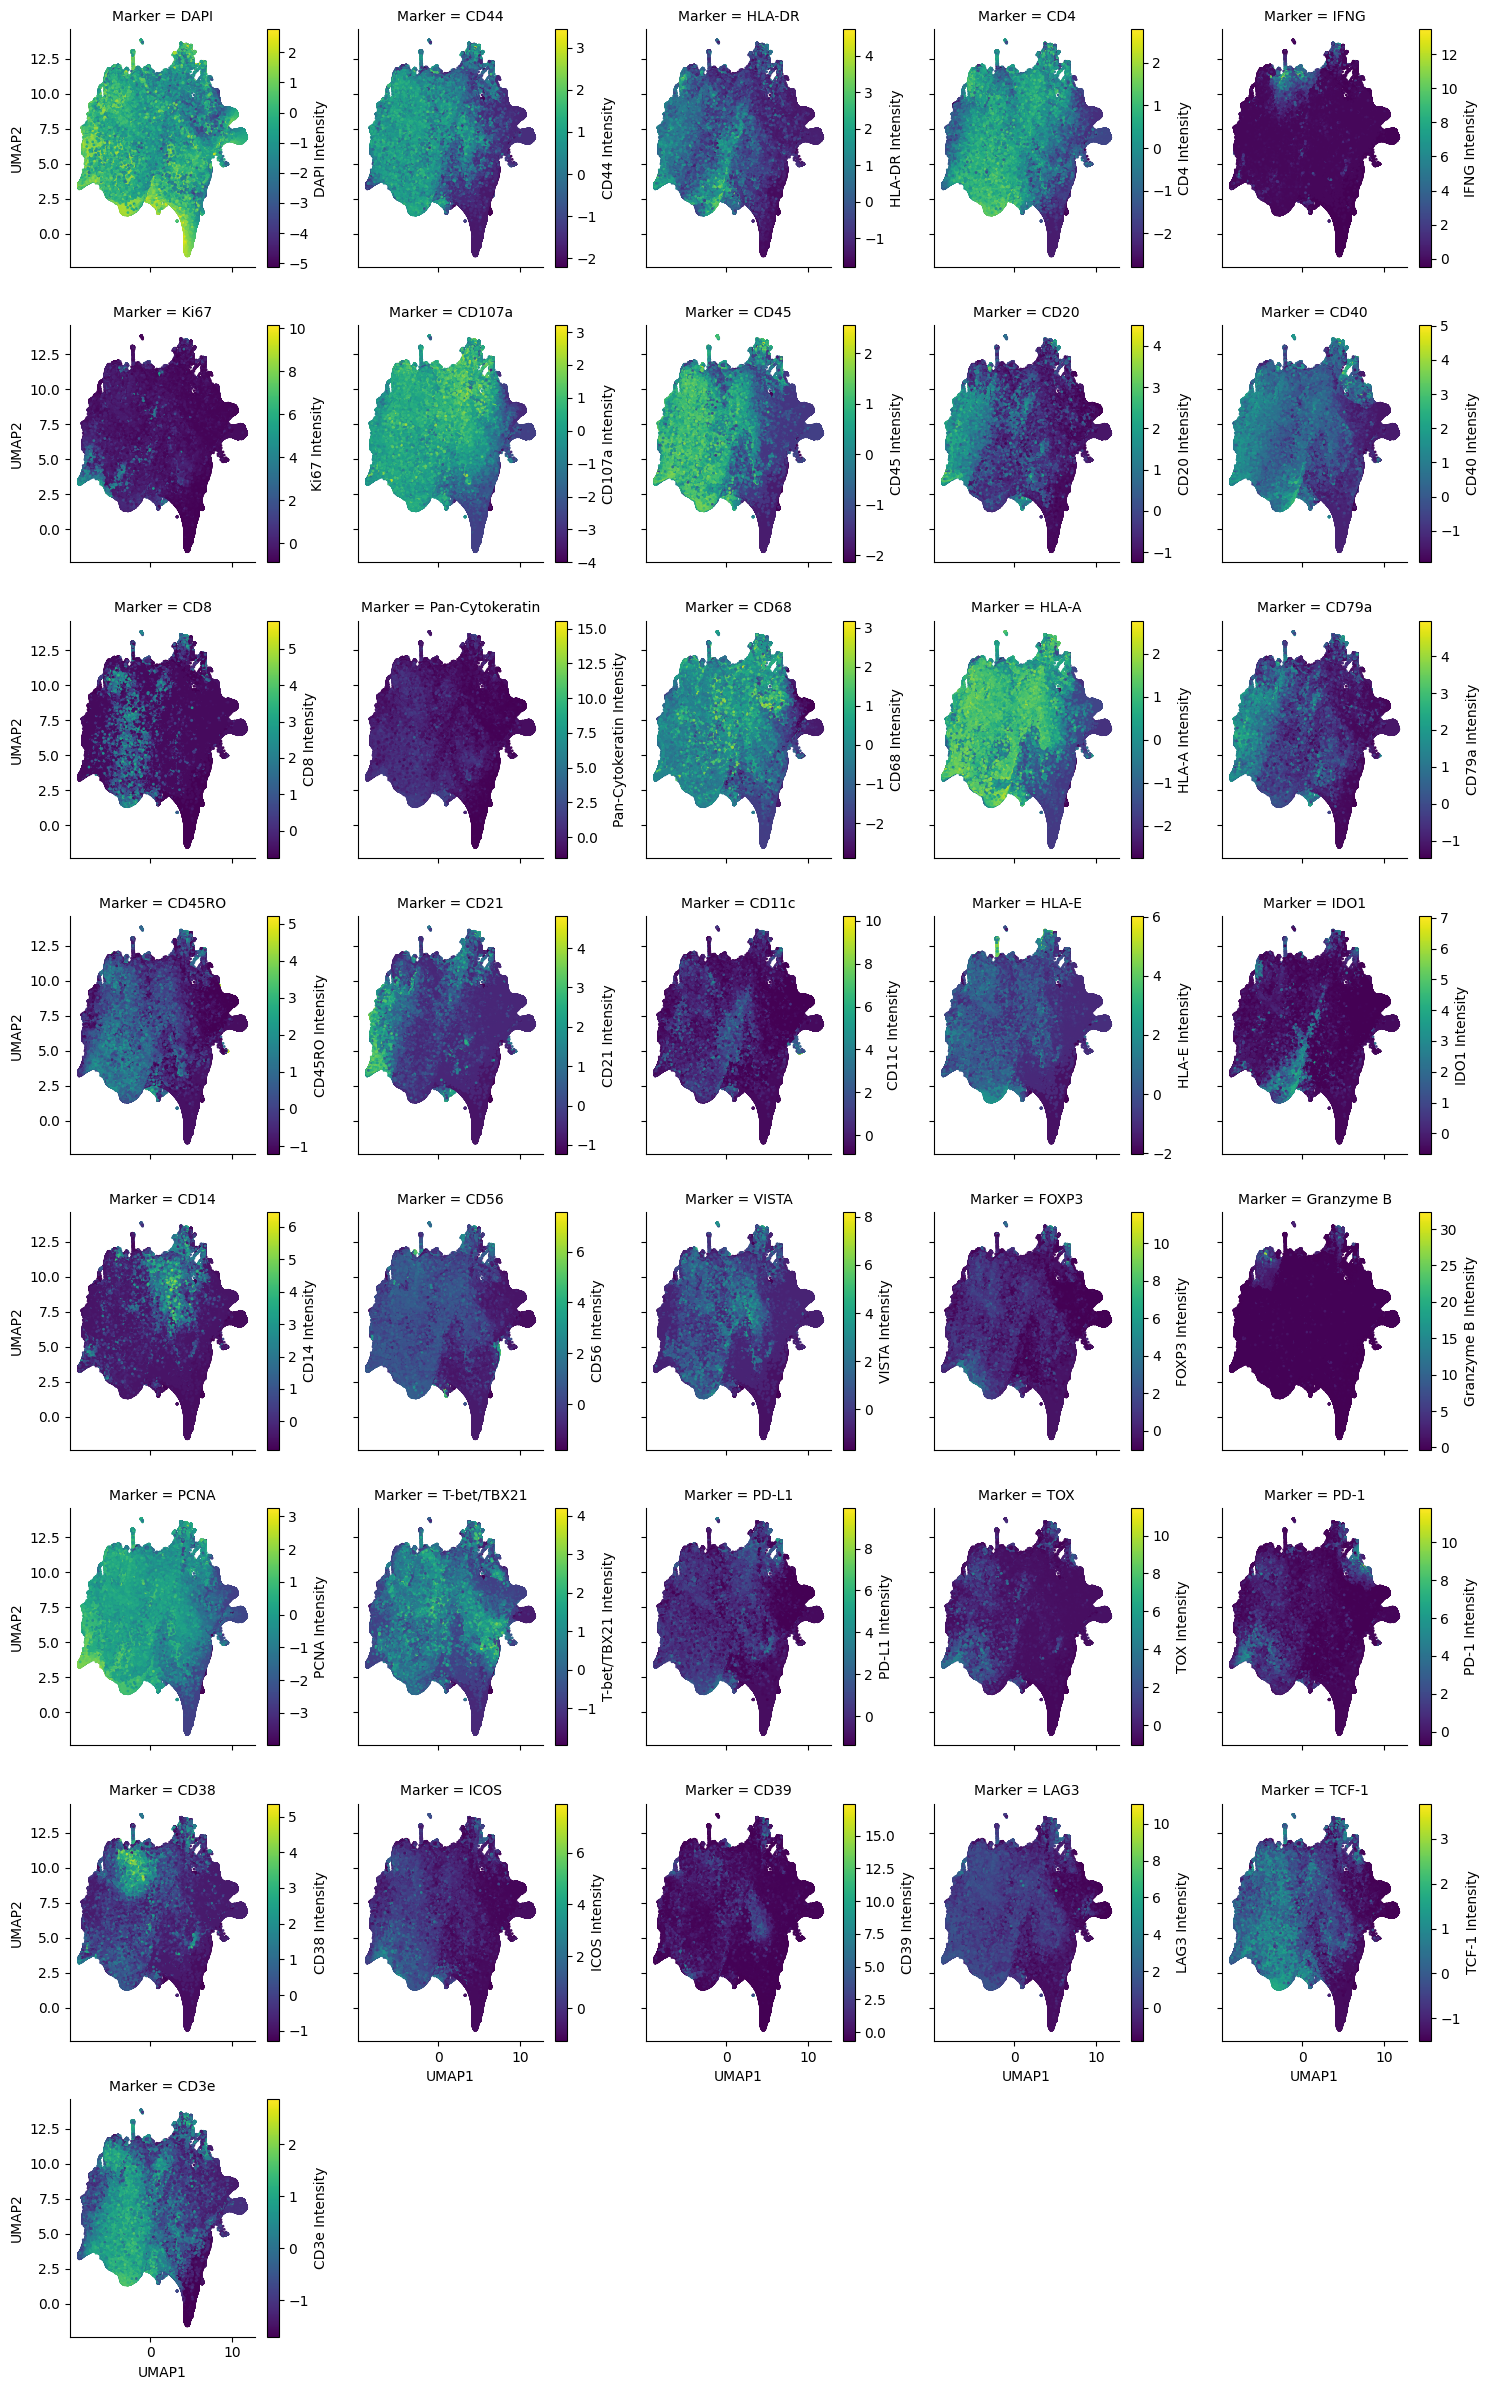

In [8]:
# plot heatmap of each marker on top of the UMAP
f = sns.FacetGrid(melted, col="Marker", col_wrap=5)
f = f.map_dataframe(
    map_scatter, "UMAP1", "UMAP2", "Intensity", s=1, cmap="viridis", vmin=0
)

In [ ]:
# plot heatmap of each marker on top of the PCA
f = sns.FacetGrid(melted, col="Marker", col_wrap=5)
f = f.map_dataframe(
    map_scatter, "PC1", "PC2", "Intensity", s=1, cmap="viridis", vmin=0
)

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


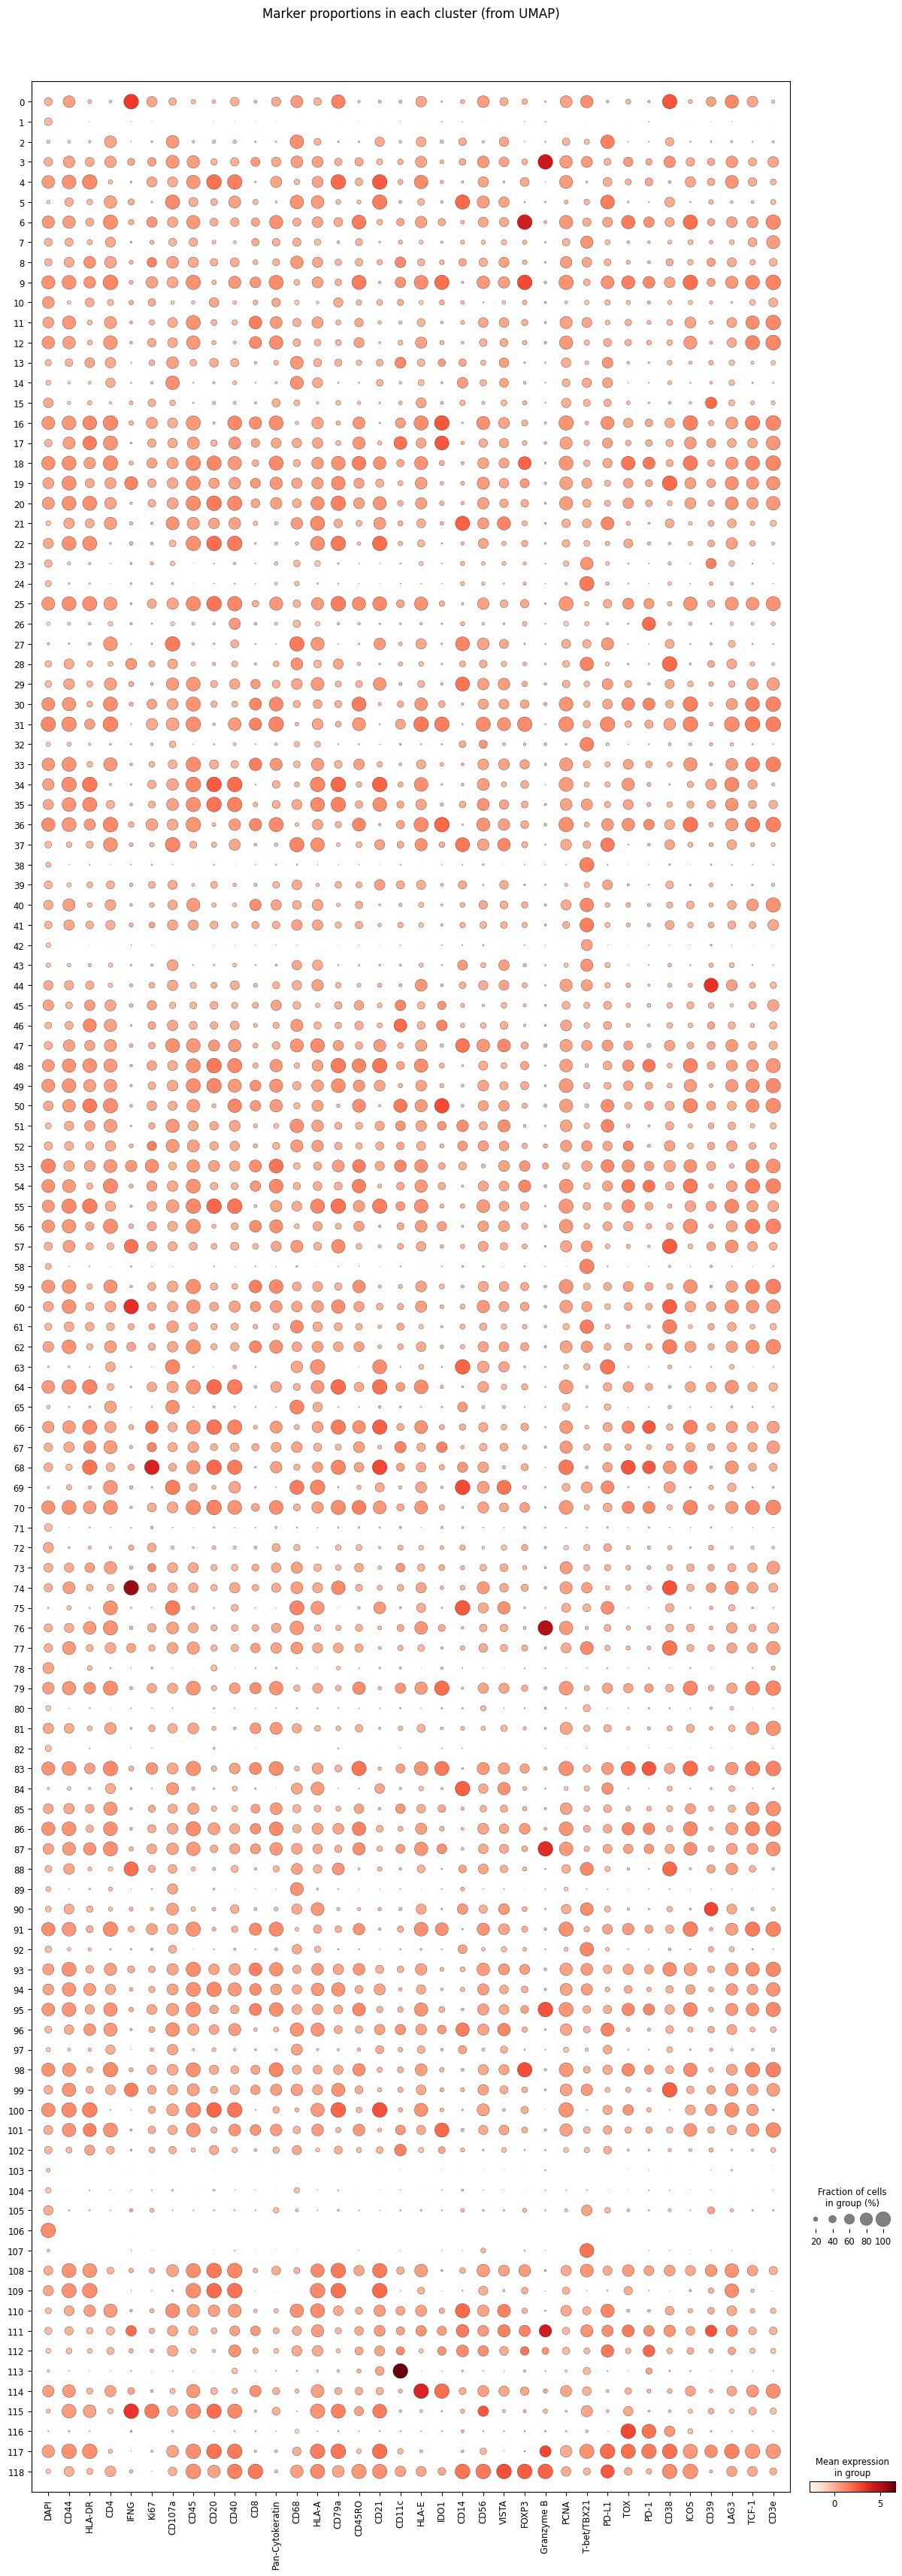

In [4]:
# dot plot of the clusters and the markers present
X = df[markers].values  # marker data as numpy array
obs = df[metadata].copy()     # metadata as a dataframe

# can use Cluster, Patient, etc. here
obs['Cluster_UMAP'] = obs['Cluster_UMAP'].astype('category')

adata = AnnData(X=X, obs=obs)

adata.var_names = markers
adata.var = pd.DataFrame(index=markers)

# make the dotplot
sc.pl.dotplot(adata, 
              var_names=markers,   # The list of markers to show on the x-axis
              groupby='Cluster_UMAP',
              title='Marker proportions in each cluster (from UMAP)'
              ) 

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


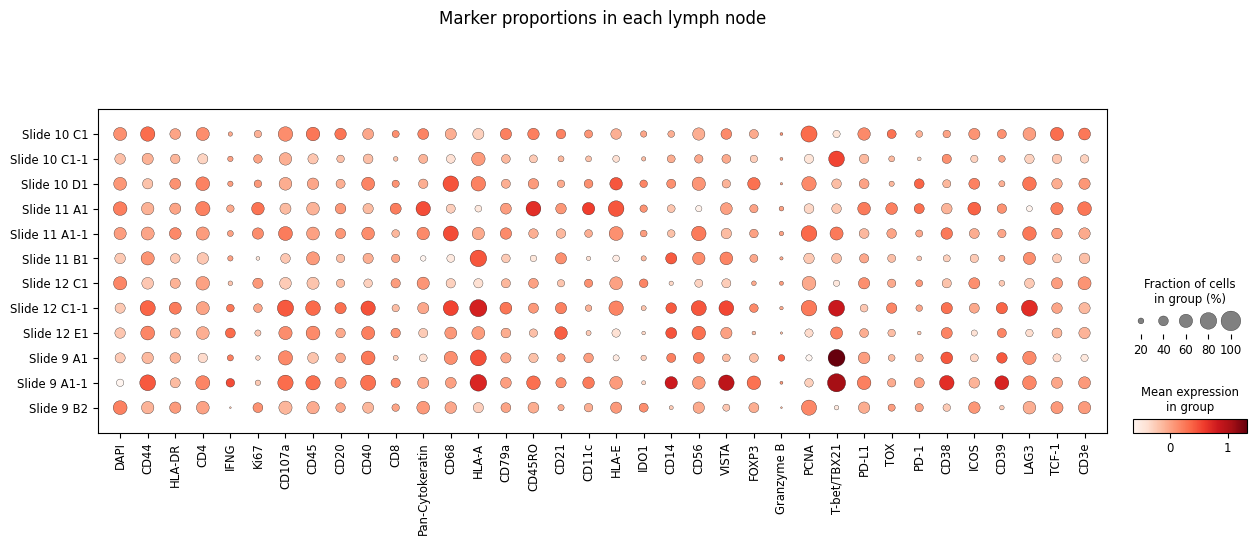

In [5]:
# dot plot of lymph node and the markers present
X = df[markers].values  # marker data as numpy array
obs = df[metadata].copy()     # metadata as a dataframe

# can use Cluster, Patient, etc. here
obs['Parent'] = obs['Parent'].astype('category')

adata = AnnData(X=X, obs=obs)

adata.var_names = markers
adata.var = pd.DataFrame(index=markers)

# make the dotplot
sc.pl.dotplot(adata, 
              var_names=markers,   # The list of markers to show on the x-axis
              groupby='Parent',
              title='Marker proportions in each lymph node'
              ) 

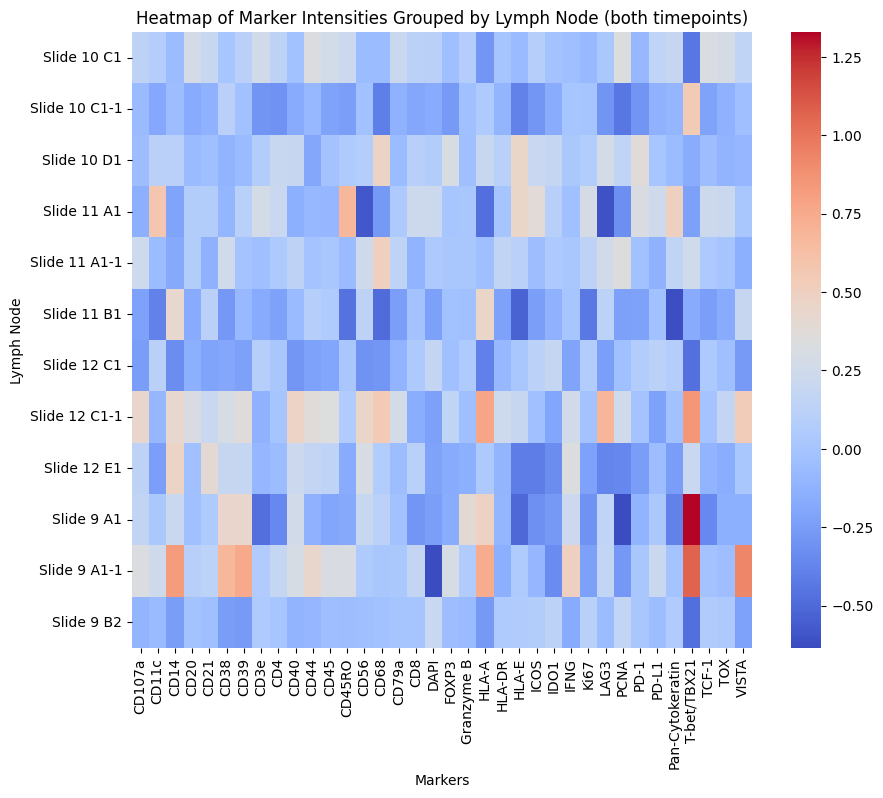

In [12]:
# heatmap of markers and lymph nodes, can see diff between pre and post
# melt data
df_long = pd.melt(df, id_vars=['Parent'], value_vars=markers, var_name='Marker', value_name='Intensity')

plt.figure(figsize=(10, 8))
sns.heatmap(df_long.pivot_table(index='Parent', columns='Marker', values='Intensity', aggfunc='mean'), cmap='coolwarm')
plt.xlabel('Markers')
plt.ylabel('Lymph Node')
plt.title('Heatmap of Marker Intensities Grouped by Lymph Node (both timepoints)')
plt.show()

In [6]:
df['Parent'].unique()

array(['Slide 10 C1-1', 'Slide 10 D1', 'Slide 10 C1', 'Slide 11 B1',
       'Slide 11 A1', 'Slide 11 A1-1', 'Slide 12 E1', 'Slide 12 C1',
       'Slide 12 C1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1'],
      dtype=object)

In [7]:
# make the 'Timepoint' column for ease of comparison
pre_timepoints = ['Slide 11 B1', 'Slide 11 A1', 'Slide 11 A1-1', 'Slide 9 A1', 'Slide 9 B2', 'Slide 9 A1-1']
df['Timepoint'] = df['Parent'].apply(lambda x: 'DLN pre' if x in pre_timepoints else 'DLN post')
print(df.head())

                   Image                             Object ID Classification  \
0  Slide10_Scan1.ome.tif  f5505ea9-ddff-4fea-90dd-a425402a544d       Other/NA   
1  Slide10_Scan1.ome.tif  4b313e44-f97c-43e8-99a7-31b9ab2a45c0       Other/NA   
2  Slide10_Scan1.ome.tif  e0673808-3a80-4490-b565-2fa9b3425738           CD56   
3  Slide10_Scan1.ome.tif  e2036b6c-b8ba-42fc-b05c-1e0c8c853192       Other/NA   
4  Slide10_Scan1.ome.tif  5afebba8-c97a-4d69-b9e2-395d49cebd90       Other/NA   

          Parent  Centroid X µm  Centroid Y µm      DAPI      CD44    HLA-DR  \
0  Slide 10 C1-1         4004.2         1674.9 -0.443124 -1.278166 -0.611227   
1  Slide 10 C1-1         4055.9         1675.2 -1.365461 -1.426814 -0.966250   
2  Slide 10 C1-1         4070.8         1675.8 -0.981877 -1.412553 -0.762933   
3  Slide 10 C1-1         3904.7         1677.1 -0.554083 -1.372611  0.236735   
4  Slide 10 C1-1         3921.0         1676.8 -0.943903 -1.384704 -0.198105   

        CD4  ...      CD39      

In [ ]:
# for each lymph node, plot cluster on top of the xy coordinates
grouped = df.groupby('Parent')
for name, group in grouped:
    # plot the xy coordinates 
    f, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(
        x="Centroid X µm", 
        y="Centroid Y µm",
        hue="Cluster",
        legend="full",
        palette="rainbow",
        data=group,
        ax=ax,
        s=10
    ).set(title=f'Lymph node {name} xy plot')

    sns.despine()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=1, borderaxespad=0.)
    plt.show()

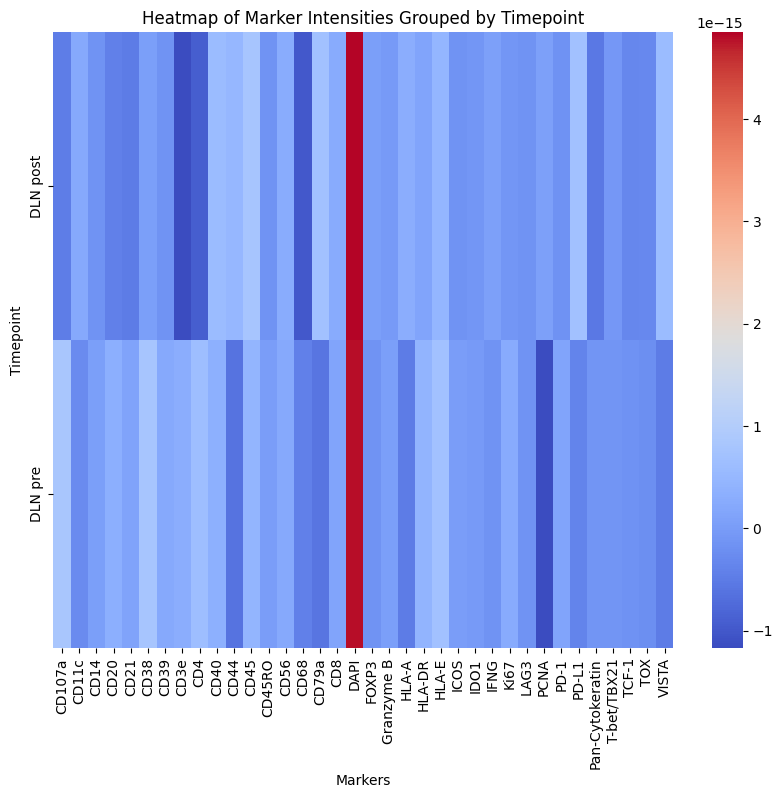

In [8]:
# heatmap of markers and lymph nodes, can see diff between pre and post
# melt data
df_long = pd.melt(df, id_vars=['Timepoint'], value_vars=markers, var_name='Marker', value_name='Intensity')

plt.figure(figsize=(10, 8))
sns.heatmap(df_long.pivot_table(index='Timepoint', columns='Marker', values='Intensity', aggfunc='mean'), cmap='coolwarm')
plt.xlabel('Markers')
plt.ylabel('Timepoint')
plt.title('Heatmap of Marker Intensities Grouped by Timepoint')
plt.show()

In [9]:
case_mappings = {'Slide 10 C1-1': 1, 'Slide 10 D1': 2, 'Slide 10 C1': 3, 'Slide 11 B1': 4,
       'Slide 11 A1': 5, 'Slide 11 A1-1': 6, 'Slide 12 E1': 4, 'Slide 12 C1': 5,
       'Slide 12 C1-1': 6, 'Slide 9 A1': 1, 'Slide 9 B2': 2, 'Slide 9 A1-1': 3}
df['KPT_Case'] = df['Parent'].map(case_mappings)
df.head()

Image                             Object ID Classification  \
0  Slide10_Scan1.ome.tif  f5505ea9-ddff-4fea-90dd-a425402a544d       Other/NA   
1  Slide10_Scan1.ome.tif  4b313e44-f97c-43e8-99a7-31b9ab2a45c0       Other/NA   
2  Slide10_Scan1.ome.tif  e0673808-3a80-4490-b565-2fa9b3425738           CD56   
3  Slide10_Scan1.ome.tif  e2036b6c-b8ba-42fc-b05c-1e0c8c853192       Other/NA   
4  Slide10_Scan1.ome.tif  5afebba8-c97a-4d69-b9e2-395d49cebd90       Other/NA   

          Parent  Centroid X µm  Centroid Y µm      DAPI      CD44    HLA-DR  \
0  Slide 10 C1-1         4004.2         1674.9 -0.443124 -1.278166 -0.611227   
1  Slide 10 C1-1         4055.9         1675.2 -1.365461 -1.426814 -0.966250   
2  Slide 10 C1-1         4070.8         1675.8 -0.981877 -1.412553 -0.762933   
3  Slide 10 C1-1         3904.7         1677.1 -0.554083 -1.372611  0.236735   
4  Slide 10 C1-1         3921.0         1676.8 -0.943903 -1.384704 -0.198105   

        CD4  ...      LAG3     TCF-1      CD3e     UMAP1     UMAP2       PC1  \
0 -0.836912  ... -1.661986 -1.439516 -0.895539  6.738408  6.757998 -5.286668   
1 -1.498882  ... -1.541051 -1.406103 -1.080230  7.695970  6.541201 -5.876908   
2 -1.413784  ... -1.088439 -0.997410 -1.053522  7.024744  7.164611 -4.714929   
3 -0.793350  ... -1.421700 -1.354550 -1.077320  6.188785  6.723613 -4.541659   
4 -1.196011  ... -1.534252 -1.337009 -1.067024  6.777853  6.659215 -5.077836   

        PC2  Cluster_UMAP  Timepoint  KPT_Case  
0 -0.298409            32   DLN post         1  
1 -0.926938            80   DLN post         1  
2 -0.376258            80   DLN post         1  
3  0.661836            32   DLN post         1  
4 -0.181445            32   DLN post         1  

[5 rows x 49 columns]

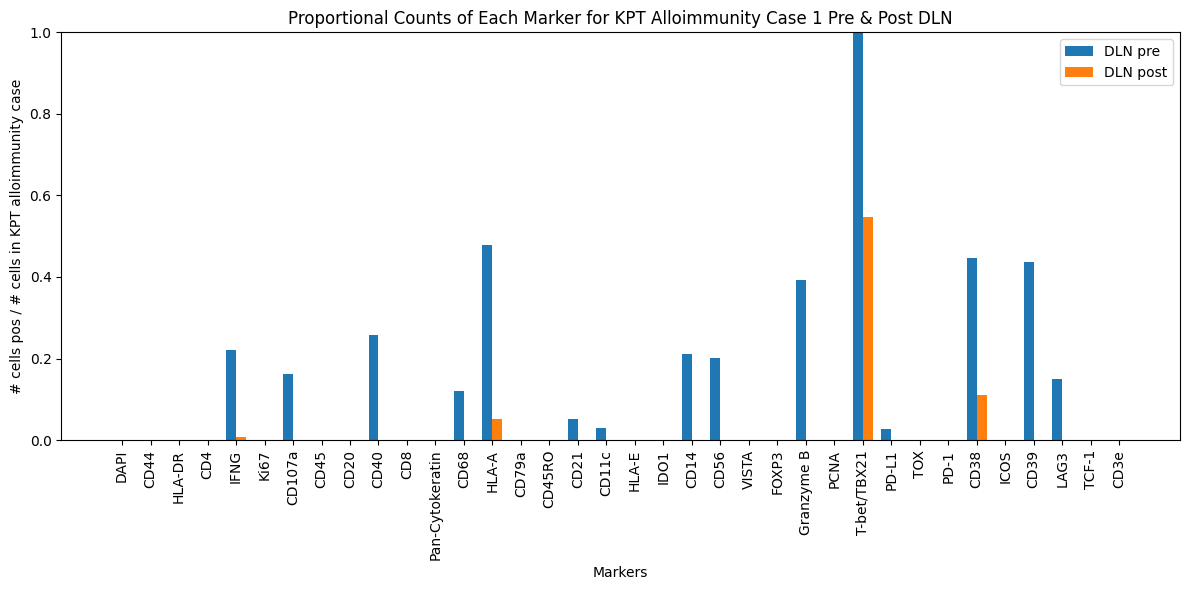

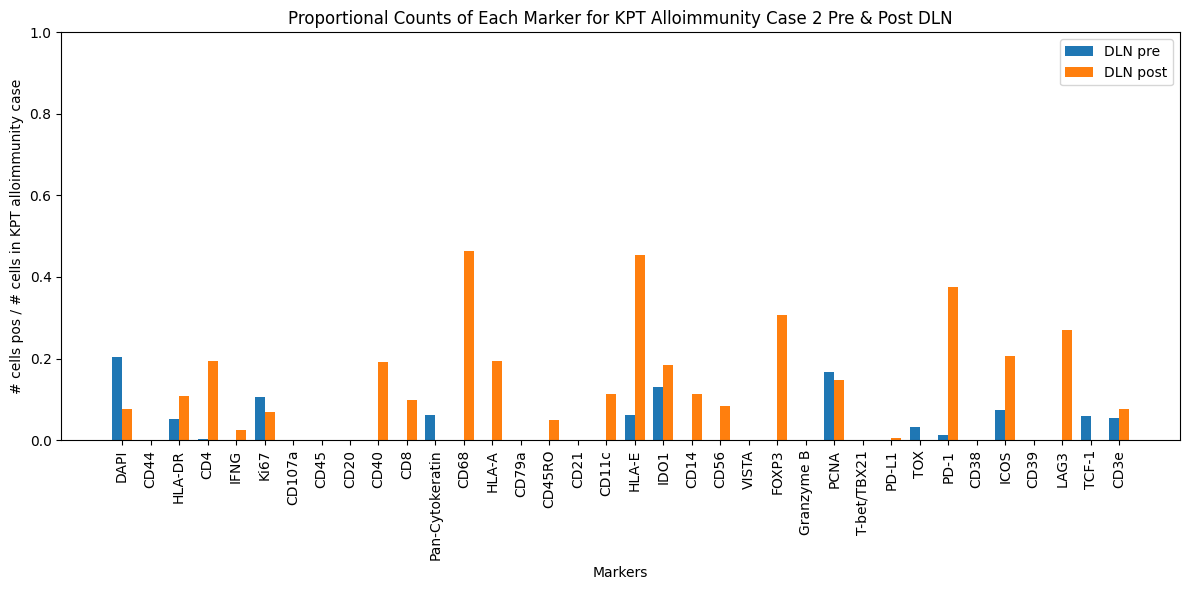

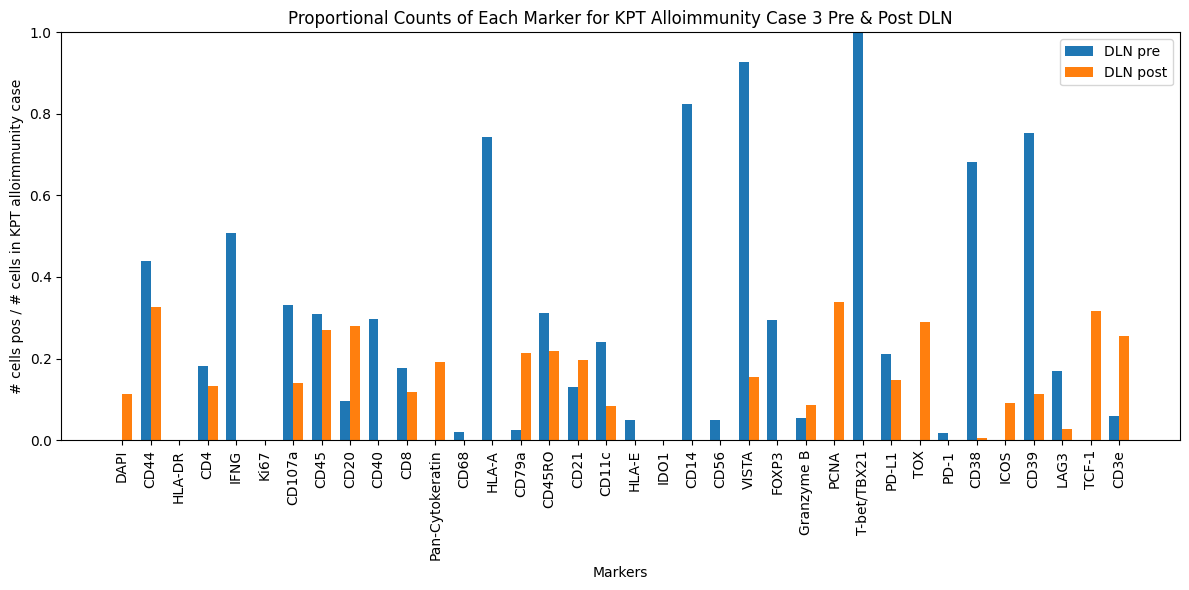

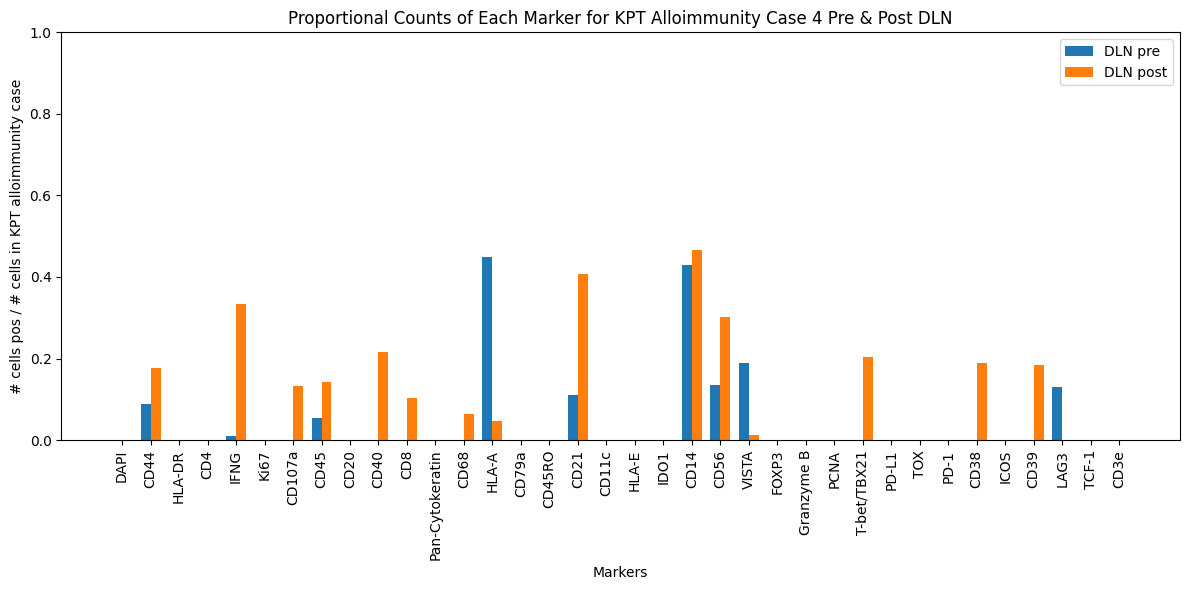

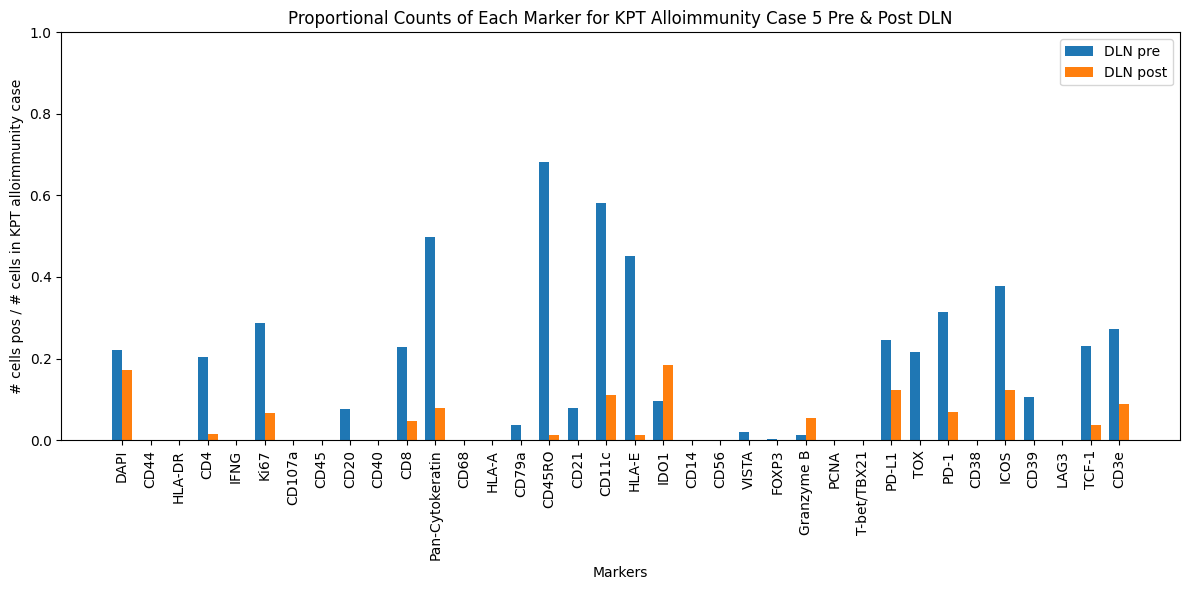

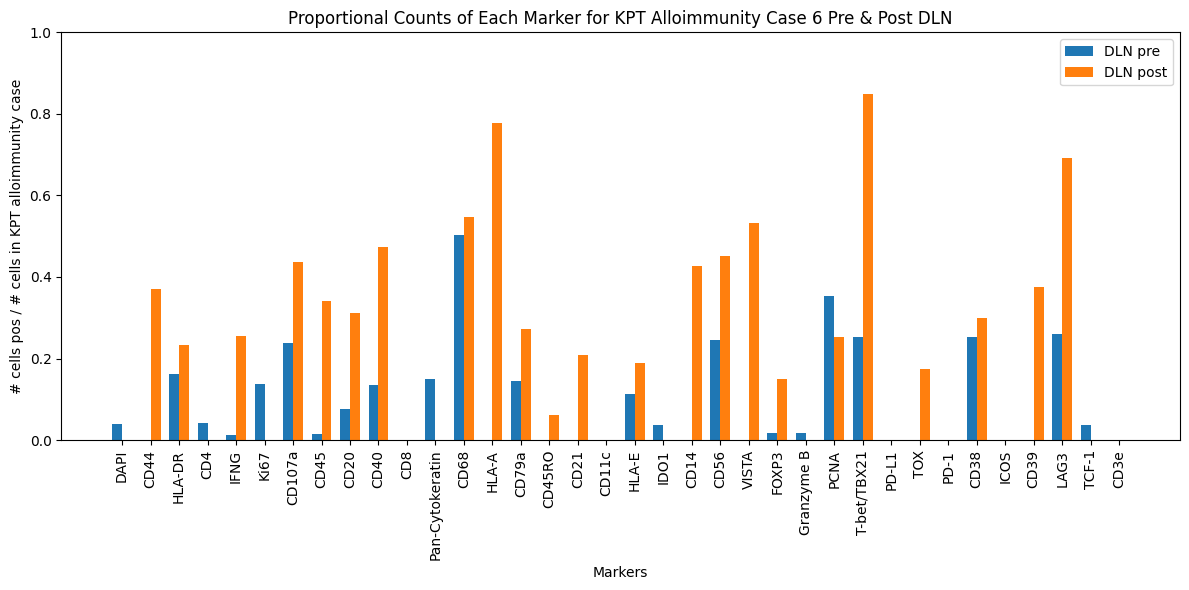

In [11]:
# bar plot of differences between timepoints
for case in df['KPT_Case'].unique():
    pre_df = df[(df['Timepoint'] == 'DLN pre') & (df['KPT_Case'] == case)]
    post_df = df[(df['Timepoint'] == 'DLN post') & (df['KPT_Case'] == case)]
    
    # calculate proportions for DLN pre
    ncells_pre = len(pre_df)
    marker_counts_pre = pre_df[markers].sum()
    prop_wrt_case_pre = marker_counts_pre / ncells_pre
    
    # calculate proportions for surgery
    ncells_post = len(post_df)
    marker_counts_post = post_df[markers].sum()
    prop_wrt_case_post = marker_counts_post / ncells_post
    
    # settings for graph
    bar_width = 0.35
    index = np.arange(len(markers))
    
    plt.figure(figsize=(12, 6))
    
    # bar plot for DLN pre
    plt.bar(index, prop_wrt_case_pre, bar_width, label='DLN pre')
    
    # bar plot for DLN post
    plt.bar(index + bar_width, prop_wrt_case_post, bar_width, label='DLN post')
    
    plt.xlabel('Markers')
    plt.ylabel('# cells pos / # cells in KPT alloimmunity case')
    plt.title(f'Proportional Counts of Each Marker for KPT Alloimmunity Case {case} Pre & Post DLN')
    plt.xticks(index + bar_width / 2, markers, rotation=90)
    plt.ylim([0, 1])
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
print(markers)

['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']


In [20]:
# level 1 classification
def classify_cells(row):
    if 'CD45RO' in row['Classification']:
        return 'CD45RO+'
    return 'Other/NA'

df['Level1'] = df.apply(classify_cells, axis=1)

# level 2 classification
def classify_level2(row):
    if row['Level1'] == 'CD45RO':
        if 'CD4' in row['Classification']:
            return 'Helper T'
        if 'CD20' in row['Classification']:
            return 'B Cell'
        else:
            return 'Other'
    return 'Other'

df['Level2'] = df.apply(classify_level2, axis=1)

In [21]:
df.head()

Image                             Object ID Classification  \
0  Slide10_Scan1.ome.tif  f5505ea9-ddff-4fea-90dd-a425402a544d       Other/NA   
1  Slide10_Scan1.ome.tif  4b313e44-f97c-43e8-99a7-31b9ab2a45c0       Other/NA   
2  Slide10_Scan1.ome.tif  e0673808-3a80-4490-b565-2fa9b3425738           CD56   
3  Slide10_Scan1.ome.tif  e2036b6c-b8ba-42fc-b05c-1e0c8c853192       Other/NA   
4  Slide10_Scan1.ome.tif  5afebba8-c97a-4d69-b9e2-395d49cebd90       Other/NA   

          Parent  Centroid X µm  Centroid Y µm      DAPI      CD44    HLA-DR  \
0  Slide 10 C1-1         4004.2         1674.9 -0.443124 -1.278166 -0.611227   
1  Slide 10 C1-1         4055.9         1675.2 -1.365461 -1.426814 -0.966250   
2  Slide 10 C1-1         4070.8         1675.8 -0.981877 -1.412553 -0.762933   
3  Slide 10 C1-1         3904.7         1677.1 -0.554083 -1.372611  0.236735   
4  Slide 10 C1-1         3921.0         1676.8 -0.943903 -1.384704 -0.198105   

        CD4  ...      CD3e     UMAP1     UMAP2       PC1       PC2  \
0 -0.836912  ... -0.895539  6.738408  6.757998 -5.286668 -0.298409   
1 -1.498882  ... -1.080230  7.695970  6.541201 -5.876908 -0.926938   
2 -1.413784  ... -1.053522  7.024744  7.164611 -4.714929 -0.376258   
3 -0.793350  ... -1.077320  6.188785  6.723613 -4.541659  0.661836   
4 -1.196011  ... -1.067024  6.777853  6.659215 -5.077836 -0.181445   

   Cluster_UMAP  Timepoint  KPT_Case    Level1  Level2  
0            32   DLN post         1  Other/NA   Other  
1            80   DLN post         1  Other/NA   Other  
2            80   DLN post         1  Other/NA   Other  
3            32   DLN post         1  Other/NA   Other  
4            32   DLN post         1  Other/NA   Other  

[5 rows x 51 columns]

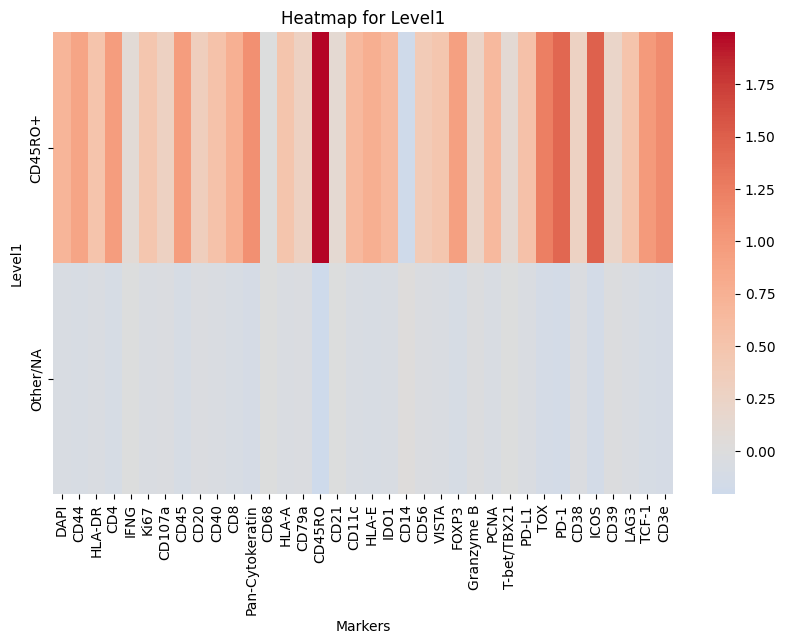

In [25]:
def plot_heatmap(data, level, markers):
    data = data.set_index(level)
    data = data[markers].astype(float)  # the data must be float for heatmap
    data = data.groupby(level).mean()  # avg expression per group

    plt.figure(figsize=(10, 6))
    sns.heatmap(data, cmap='coolwarm', center=0)
    plt.title(f'Heatmap for {level}')
    plt.xlabel('Markers')
    plt.ylabel(level)
    plt.show()

plot_heatmap(df, 'Level1', markers)
# plot_heatmap(df, 'Level2', markers)